## 1. Set Up

In [1]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 6.8 MB/s eta 0:00:00


In [2]:
#Am I running a GPU and what type is it?
!nvidia-smi

Sun Mar 12 08:14:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = torch.device("cpu")
     

Number of GPU(s) available: 1
GPU device name: Tesla T4


In [4]:
from logging import warning
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import BertTokenizer, BertModel

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# from sklearn.utils import resample
# from sklearn.model_selection import train_test_split

import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime
from collections import Counter

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

pd.set_option('display.max_colwidth', 100)
sns.set(style='whitegrid')


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd drive/MyDrive/w266

/content/drive/MyDrive/w266


In [8]:
# !git clone https://github.com/hjesse92/style_transfer_w266.git

In [9]:
cd style_transfer_w266/

/content/drive/MyDrive/w266/style_transfer_w266


In [10]:
# !git checkout -b eda_basemodel
# !git branch

In [11]:
!ls data/

jigsaw_classification_data.csv	original-test.tsv
original-dev.tsv		original-train.tsv


## 2. EDA

In [12]:
train_text_file = 'data/original-train.tsv'
dev_text_file = 'data/original-dev.tsv'
test_text_file = 'data/original-test.tsv'

In [13]:
def load_data(text_file):
  """Load data and rename column"""
  df = pd.read_csv(text_file, sep="\t")
  df = df.rename(columns={'offensive-text':'org', 'style-transferred-text': 'mod'})
  
  # Calculate text length / word counts
  df['org_text_length'] = df['org'].apply(lambda x: len(x.split(' ')))
  df['mod_text_length'] = df['mod'].apply(lambda x: len(x.split(' ')))

  return df

In [14]:
def modify_text_to_print(df_original):
  """Modify some toxic, offensive texts in the datafram for printing out"""
  df = df_original.copy()
  df["org"] = df["org"].apply(lambda x: x.lower().replace('fuck', 'f***')\
                              .replace('shit', 's***')\
                              .replace('rape', 'r***')\
                              .replace('dick', 'd***')\
                              .replace('pussy', 'p***y'))

  return df

In [15]:
train_df = load_data(train_text_file)
dev_df = load_data(dev_text_file)
test_df = load_data(test_text_file)

print('Train data size:', train_df.shape[0])
print('Dev data size:', dev_df.shape[0])
print('Test data size:', test_df.shape[0])

print('\nTrain data overview:')
modify_text_to_print(train_df[["org", "mod"]])

Train data size: 1584
Dev data size: 198
Test data size: 199

Train data overview:


,org,mod
0,p***y nobody asked for your input.,Nobody asked for your input
1,"ok, this makes no sense. this will create vigilantes. and i hope they put this savage animal dow...","Ok, this makes no sense. This will create vigilantes. And I hope they take care of this uncontro..."
2,so f***ing true. the amount of up and coming rappers that are shot dead or od is is so f***ing s...,so true. the amount of up and coming rappers that are shot dead or od is is so sad.
3,go f yourself republican scum who put us here with your uneducated voting like you even care. i ...,Republicans put us in this situation. I would want to defund the police.
4,dumb f***ing take. people want to do things.,That's not a smart take. People want to do things.
...,...,...
1579,"the view! and this crap hits my front page!? lmfao i know it's mostly bots but still, /r/polit...","This must be mostly bots but still, it's strange for /r/politics."
1580,that’s racist.,Those actions are racist.
1581,cultural marxism isn't a thing you weird f***.,Cultural Marxism isn't a thing.
1582,"lol, anyone that questions the democrat program is always a russian asset or nazi. this s***s ol...","LOL, anyone that questions the Democrat program is always considered back. This is getting old, ..."


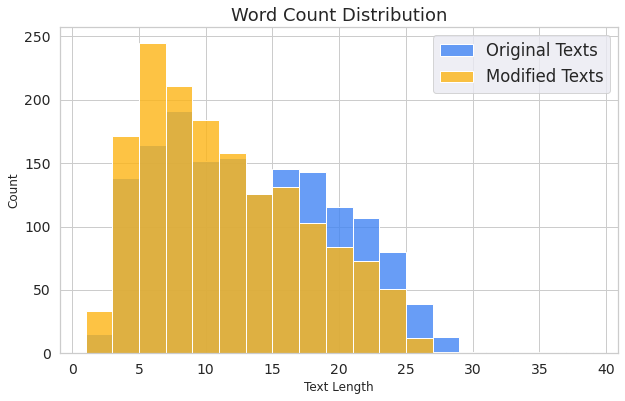

In [16]:
### Plot the word-count distribution for the original texts and the modified texts.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')
sns.set(font_scale=1.5)

# calculate the bin size based on the range of the data
bins = range(min(train_df['org_text_length'].min(), train_df['mod_text_length'].min()), 
             max(train_df['org_text_length'].max(), train_df['mod_text_length'].max()) + 2, 2)

# plot the histograms with the same bin size
sns.histplot(data=train_df, x='org_text_length', label='Original Texts', bins=bins, color='#4285F4', alpha=0.8)
sns.histplot(data=train_df, x='mod_text_length', label='Modified Texts', bins=bins, color='#FDB515', alpha=0.8)

# set the axis labels and title
ax.set(xlabel='Text Length', ylabel='Count')
ax.set_title('Word Count Distribution', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)
plt.legend(loc='upper right')

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [17]:
### Find out what words appear the most in the original texts and the modified text without including the stopwords

# create a list of stopwords
stop_words = set(stopwords.words('english')) | {"i'm", "you’re", "that's"}

# create a list of all words in the 'org' column, removing stopwords
org_words = ' '.join(train_df['org']).lower().split()
org_words = [word.strip(".,?!:").replace('fuck', 'f***').replace('shit', 's***') for word in org_words if word not in stop_words]
# org_words = [word.lower() for word in train_df['org'].str.split() if word.lower() not in stop_words]

# create a list of all words in the 'mod' column, removing stopwords
mod_words = ' '.join(train_df['mod']).lower().split()
mod_words = [word.strip(".,?!:") for word in mod_words if word not in stop_words]
# mod_words = [word.lower() for word in train_df['mod'].str.split() if word.lower() not in stop_words]

# count the frequency of each word in the 'org' column
org_word_counts = Counter(org_words)

# count the frequency of each word in the 'mod' column
mod_word_counts = Counter(mod_words)

# create a pandas dataframe of the top 20 most common words in each column
top_org_words = pd.DataFrame(org_word_counts.most_common(20), columns=['word', 'count'])
top_mod_words = pd.DataFrame(mod_word_counts.most_common(20), columns=['word', 'count'])

# print the top 20 most common words in each column
print("Top 20 most frequent words in the Original Texts:")
print(top_org_words)
print("\nTop 20 most frequent words in the Modified Texts:")
print(top_mod_words)

Top 20 most frequent words in the Original Texts:
       word  count
0      f***    170
1      s***    158
2   f***ing    138
3      like    119
4    people     90
5    stupid     84
6       get     78
7      dumb     57
8      even     52
9      know     52
10    think     52
11      lol     51
12    idiot     50
13       go     48
14      one     45
15   really     43
16      ass     43
17   racist     42
18     good     42
19    right     38

Top 20 most frequent words in the Modified Texts:
      word  count
0   people    129
1     like    104
2      get     78
3    think     67
4   really     58
5     know     52
6   person     51
7     good     49
8     make     48
9     stop     47
10    even     46
11     one     46
12    need     46
13      go     45
14     bad     44
15      it     43
16   would     37
17     lol     35
18  racist     34
19   stuff     34


In [18]:
# from datasets import load_dataset
# train_ds = load_dataset("csv", data_files=train_text_file, sep="\t", names=["org","mod"])
# train_ds
# print(train_ds["train"][:5])

## 3. Evaluate Detoxify Dataset with Classification Model

*   Using the Toxic DistilBert Classification model to evaluate the detoxify dataset
*   Column `org` should be classified as being toxic Or having low non-toxic score
*   Column `mod` should be classified as being non-toxic Or having high non-toxic score





In [19]:
# Clear out cuda
torch.cuda.empty_cache()

In [20]:
!ls ./notebooks

Classification_Model_NonToxicScore2.ipynb	     EDA_Basemodel.ipynb
Classification_Model_NonToxicScore_DistilBERT.ipynb  first.ipynb
Classification_Model_NonToxicScore.ipynb	     __pycache__
DistilBertClassification.py


In [21]:
import sys
sys.path.append('./notebooks')
# import DistilBertClassification as dbc
from DistilBertClassification import BertClassification

class_model = BertClassification()
class_model = class_model.to(device)

pretrained_weights = torch.load('models/DistilBertToxicClassification1.pth')
class_model.load_state_dict(pretrained_weights )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [22]:
# Get pair-wise toxic and non-toxic (transfered-style) data
toxic_inputs = train_df["org"]
nontoxix_targets = train_df["mod"]

print('Toxic Data Dimension:', toxic_inputs.shape)
print('NonToxic Data Dimension:', nontoxix_targets.shape)
print('Toxic Data Example:' , toxic_inputs[:5])
print('NonToxic Data Example:' , nontoxix_targets[:5])

Toxic Data Dimension: (1584,)
NonToxic Data Dimension: (1584,)
Toxic Data Example: 0                                                                     Pussy nobody asked for your input.
1    Ok, this makes no sense. This will create vigilantes. And I hope they put this savage animal dow...
2    so fucking true. the amount of up and coming rappers that are shot dead or od is is so fucking s...
3    Go f yourself Republican scum who put us here with your uneducated voting like you even care. I ...
4                                                           Dumb fucking take. People want to do things.
Name: org, dtype: object
NonToxic Data Example: 0                                                                            Nobody asked for your input
1    Ok, this makes no sense. This will create vigilantes. And I hope they take care of this uncontro...
2                    so true. the amount of up and coming rappers that are shot dead or od is is so sad.
3                            

In [23]:
from transformers import DistilBertTokenizer

# Load DistilBERT tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Max_length used from pretrained model
max_length = 64

toxic_inputs_encodings = bert_tokenizer(
    list(toxic_inputs.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

nontoxix_targets_encodings = bert_tokenizer(
    list(nontoxix_targets.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

In [24]:
## DataLoader
toxic_ids = toxic_inputs_encodings.input_ids.to(device, dtype = torch.long)
toxic_mask = toxic_inputs_encodings.attention_mask.to(device, dtype = torch.long)
toxic_labels = torch.zeros(toxic_inputs.shape[0])

nontoxic_ids = nontoxix_targets_encodings.input_ids.to(device, dtype = torch.long)
nontoxic_mask = nontoxix_targets_encodings.attention_mask.to(device, dtype = torch.long)
nontoxic_labels = torch.ones(nontoxix_targets.shape[0])

toxic_dataset = TensorDataset(toxic_ids, toxic_mask, toxic_labels)
toxic_loader = DataLoader(toxic_dataset, batch_size=16)

non_toxic_dataset = TensorDataset(nontoxic_ids, nontoxic_mask, nontoxic_labels)
nontoxic_loader = DataLoader(non_toxic_dataset, batch_size=16)

In [25]:
from DistilBertClassification import validate, compute_metrics

## Get the predicted nontoxic score (or label from classification model)
toxic_outputs, toxic_targets, toxic_loss = validate(toxic_loader, model=class_model)
print('Evaluation metric for predicting toxic texts with DistilBERT:')
toxic_accuracy = compute_metrics(toxic_outputs, toxic_targets)

                
nontoxic_outputs, nontoxic_targets, nontoxic_loss = validate(nontoxic_loader, model=class_model)
print('\nEvaluation metric for predicting non-toxic texts with DistilBERT:')
nontoxic_accuracy = compute_metrics(nontoxic_outputs, nontoxic_targets)

Evaluation metric for predicting toxic texts with DistilBERT:
Accuracy 0.9545 


Evaluation metric for predicting non-toxic texts with DistilBERT:
Accuracy 0.5840 



In [27]:
toxic_outputs[:10]

[0.0020149836782366037,
 0.18502932786941528,
 0.0020377133041620255,
 0.0022846253123134375,
 0.0017857957864180207,
 0.001972738653421402,
 0.004729583393782377,
 0.008347856812179089,
 0.003270878456532955,
 0.01146689336746931]

In [28]:
nontoxic_outputs[:10]

[0.9926396608352661,
 0.507552444934845,
 0.4513583183288574,
 0.9533113837242126,
 0.826048731803894,
 0.9779512882232666,
 0.8832764625549316,
 0.9687812328338623,
 0.9919959306716919,
 0.02275126986205578]

In [32]:
print('NonToxicScore for the toxic posts: {:.4f}'.format(np.mean(toxic_outputs)))
print('NonToxicScore for the style-transfered posts: {:.4f}'.format(np.mean(nontoxic_outputs)))

NonToxicScore for the toxic posts: 0.0565
NonToxicScore for the style-transfered posts: 0.5700
